# DoH detection using NetTiSA flows

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [2]:
df = pd.read_csv("../final_datasets/doh_real_world.csv")

In [3]:
df

,Unnamed: 0,SRC_IP,DST_IP,SRC_PORT,DST_PORT,TIME_FIRST,TIME_LAST,LABEL,PACKETS,PACKETS_REV,...,ROOT_MEAN_SQUARE,KURTOSIS,TIME_DISTRIBUTION,MEAN_RELATIVE_TIME,DURATION,MEAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,SWITCHING_METRIC,DIRECTIONS
0,0,199.33.242.28,104.16.248.249.,10405,443,1.627832e+09,1.627832e+09,True,2,0,...,116.867446,0.250000,0.500000,0.007508,0.015015,0.015015,0.015015,0.015015,2.000000,1.0
1,1,104.16.248.249,199.33.242.28.,443,10405,1.627832e+09,1.627832e+09,True,1,0,...,164.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.0
2,2,7295:7731:224:92e:1744:c234:e720:f59f,2606:4700::6810:f8f9.,35256,443,1.627832e+09,1.627832e+09,True,6,0,...,121.954226,0.701398,0.566047,38.605917,68.202678,13.640536,0.007496,47.604121,2.000000,1.0
3,3,2606:4700::6810:f8f9,7295:7731:224:92e:1744:c234:e720:f59f.,443,35256,1.627832e+09,1.627832e+09,True,3,0,...,171.000000,0.000000,0.566056,38.601811,68.194277,34.097139,20.583121,47.611156,0.000000,1.0
4,4,7295:7731:224:92e:1744:c234:e720:f59f,2606:4700::6810:f8f9.,35256,443,1.627833e+09,1.627833e+09,True,2,0,...,121.492798,0.250196,0.500000,0.004771,0.009543,0.009543,0.009543,0.009543,2.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591897,5591897,10.76.167.128,173.234.109.172.,443,54986,1.634845e+09,1.634845e+09,False,184078,0,...,1517.052645,289.905876,0.542603,22.258196,41.021124,0.000223,0.000000,1.088002,0.021752,1.0
5591898,5591898,173.234.109.172,248.33.143.215.,55227,443,1.634845e+09,1.634845e+09,False,11,0,...,781.446968,1.610430,0.498982,0.460338,0.922553,0.092255,0.000000,0.357041,1.400000,1.0
5591899,5591899,248.33.143.215,173.234.109.172.,443,55227,1.634845e+09,1.634845e+09,False,11,0,...,963.022798,1.038964,0.433140,0.313498,0.723781,0.072378,0.000000,0.303155,1.000000,1.0
5591900,5591900,206.72.85.24,102.214.20.44.,56730,443,1.634845e+09,1.634845e+09,False,1,0,...,60.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.0


In [58]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "KURTOSIS",
    "TIME_DISTRIBUTION",
    "MEAN_RELATIVE_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
]

In [59]:
import sklearn
pd.set_option('display.max_columns', None)

df = df[["LABEL"] + features].copy()

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes


for F in features:
    df.replace([np.inf], 0, inplace=True)
    df.replace([-np.inf], 0, inplace=True)
    df.loc[df[F].isnull(), F] = 0

In [60]:
df

,LABEL,PACKETS,PACKETS_REV,BYTES,BYTES_REV,MEAN,STDEV,VAR,BURSTINESS,MIN,MAX,MIN_MINUS_MAX,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,KURTOSIS,TIME_DISTRIBUTION,MEAN_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,SWITCHING_METRIC,DIRECTIONS,LABEL_code
0,True,2,0,94,0,107,66.468037,4418,-0.233657,60,154,94,62.119661,47,43.925234,116.867446,0.250000,0.500000,0.007508,0.015015,0.015015,0.015015,0.015015,2.000000,1.0,1
1,True,1,0,104,0,164,164.000000,0,0.000000,164,164,0,100.000000,0,0.000000,164.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1
2,True,6,0,305,0,110,55.731499,3107,-0.327448,60,166,106,50.664999,50,45.454545,121.954226,0.701398,0.566047,38.605917,68.202678,13.640536,0.007496,47.604121,2.000000,1.0,1
3,True,3,0,333,0,171,0.000000,0,-1.000000,171,171,0,0.000000,0,0.000000,171.000000,0.000000,0.566056,38.601811,68.194277,34.097139,20.583121,47.611156,0.000000,1.0,1
4,True,2,0,101,0,110,71.414284,5101,-0.212694,60,161,101,64.922077,50,45.454545,121.492798,0.250196,0.500000,0.004771,0.009543,0.009543,0.009543,0.009543,2.000000,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591897,False,184078,0,267951804,0,1515,65.383484,4276,-0.917256,60,1520,1460,4.315742,9,0.594059,1517.052645,289.905876,0.542603,22.258196,41.021124,0.000223,0.000000,1.088002,0.021752,1.0,0
5591898,False,11,0,5187,0,531,600.774500,360931,0.061651,60,1500,1440,113.140207,505,95.103578,781.446968,1.610430,0.498982,0.460338,0.922553,0.092255,0.000000,0.357041,1.400000,1.0,0
5591899,False,11,0,7112,0,706,686.314068,471027,-0.014139,60,1520,1460,97.211624,619,87.677054,963.022798,1.038964,0.433140,0.313498,0.723781,0.072378,0.000000,0.303155,1.000000,1.0,0
5591900,False,1,0,0,0,60,60.000000,0,0.000000,60,60,0,100.000000,0,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0


In [61]:
print(f"hod: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

hod: 5139605	clear: 452297


In [62]:
df = df[["LABEL_code"] + features].copy()

In [63]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [64]:
print(f"doh: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

doh: 5139605	clear: 452297


In [65]:
df_validation = df.sample(n=500000)
df_features =  df[~df.isin(df_validation)].dropna()

In [66]:
len(df_features)

5091902

In [67]:
len(df_features)*0.7

3564331.4

In [68]:
len(df_features) - 3564331

1527571

In [69]:
df_features

,LABEL_code,PACKETS,PACKETS_REV,BYTES,BYTES_REV,MEAN,STDEV,VAR,BURSTINESS,MIN,MAX,MIN_MINUS_MAX,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,KURTOSIS,TIME_DISTRIBUTION,MEAN_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,SWITCHING_METRIC,DIRECTIONS
1,1.0,1.0,0.0,104.0,0.0,164.0,164.000000,0.0,0.000000,164.0,164.0,0.0,100.000000,0.0,0.000000,164.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2,1.0,6.0,0.0,305.0,0.0,110.0,55.731499,3107.0,-0.327448,60.0,166.0,106.0,50.664999,50.0,45.454545,121.954226,0.701398,0.566047,38.605917,68.202678,13.640536,0.007496,47.604121,2.000000,1.0
3,1.0,3.0,0.0,333.0,0.0,171.0,0.000000,0.0,-1.000000,171.0,171.0,0.0,0.000000,0.0,0.000000,171.000000,0.000000,0.566056,38.601811,68.194277,34.097139,20.583121,47.611156,0.000000,1.0
4,1.0,2.0,0.0,101.0,0.0,110.0,71.414284,5101.0,-0.212694,60.0,161.0,101.0,64.922077,50.0,45.454545,121.492798,0.250196,0.500000,0.004771,0.009543,0.009543,0.009543,0.009543,2.000000,1.0
5,1.0,1.0,0.0,110.0,0.0,170.0,170.000000,0.0,0.000000,170.0,170.0,0.0,100.000000,0.0,0.000000,170.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591897,0.0,184078.0,0.0,267951804.0,0.0,1515.0,65.383484,4276.0,-0.917256,60.0,1520.0,1460.0,4.315742,9.0,0.594059,1517.052645,289.905876,0.542603,22.258196,41.021124,0.000223,0.000000,1.088002,0.021752,1.0
5591898,0.0,11.0,0.0,5187.0,0.0,531.0,600.774500,360931.0,0.061651,60.0,1500.0,1440.0,113.140207,505.0,95.103578,781.446968,1.610430,0.498982,0.460338,0.922553,0.092255,0.000000,0.357041,1.400000,1.0
5591899,0.0,11.0,0.0,7112.0,0.0,706.0,686.314068,471027.0,-0.014139,60.0,1520.0,1460.0,97.211624,619.0,87.677054,963.022798,1.038964,0.433140,0.313498,0.723781,0.072378,0.000000,0.303155,1.000000,1.0
5591900,0.0,1.0,0.0,0.0,0.0,60.0,60.000000,0.0,0.000000,60.0,60.0,0.0,100.000000,0.0,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


In [70]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [71]:
X = df_features[features]
y = df_features.LABEL_code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [72]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 10, 100, 10),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,90,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 2),
        'n_estimators': hp.quniform('n_estimators', 100, 400, 100),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [73]:
df_to_tunne = df_features.sample(250000)
best_hyperparams = tunne_together_XGBoost_classification(df_to_tunne, features, verbose=False)

100%|██████████| 100/100 [15:09<00:00,  9.10s/trial, best loss: -0.978179875333927]
The best hyperparameters are :  

{'colsample_bytree': 0.5943384599436915, 'gamma': 2.7370786371620923, 'max_depth': 80.0, 'min_child_weight': 6.0, 'n_estimators': 300.0, 'reg_alpha': 3.0, 'reg_lambda': 0.3225894518907485}


In [74]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        #Split on train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        model = XGBClassifier(
                n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                colsample_bytree=int(best_hyperparams['colsample_bytree']),
                # subsample=int(best_hyperparams['subsample']),
                # eta=best_hyperparams['eta'],
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if best_results[0] < accuracy:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (accuracy, "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1), matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

0


96.86214257798818
96.86 & 97.11 & 99.55 & 98.31 \\


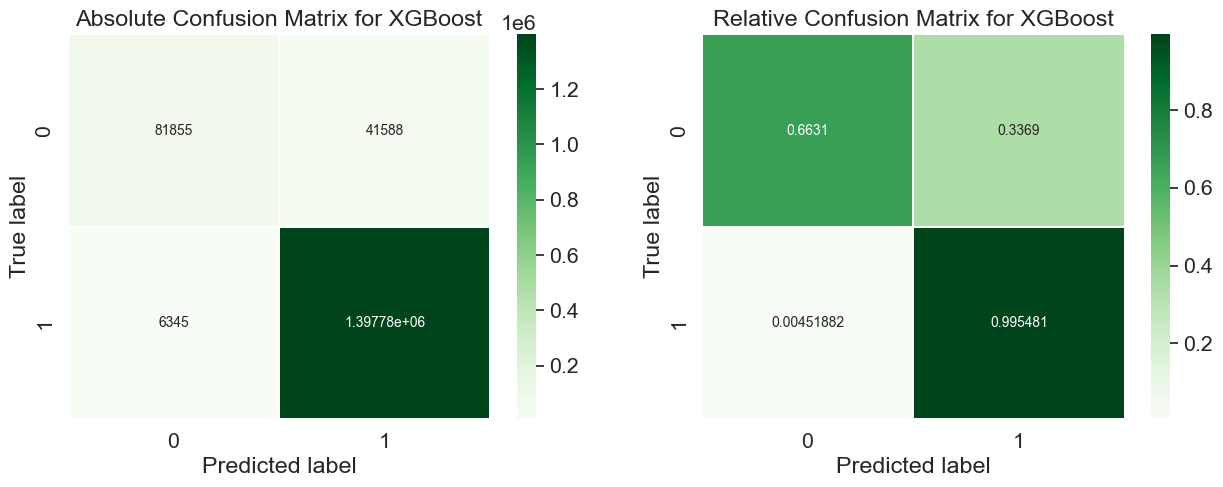

In [75]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=1)

# Validation

96.78 & 97.03 & 99.54 & 98.27 \\


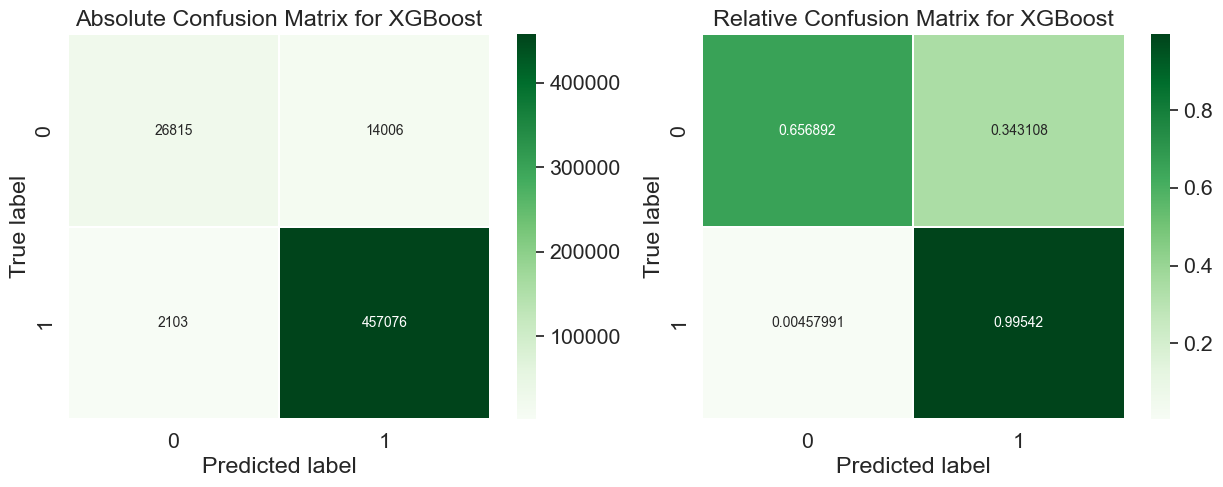

In [76]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
print("{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

# Feature importance

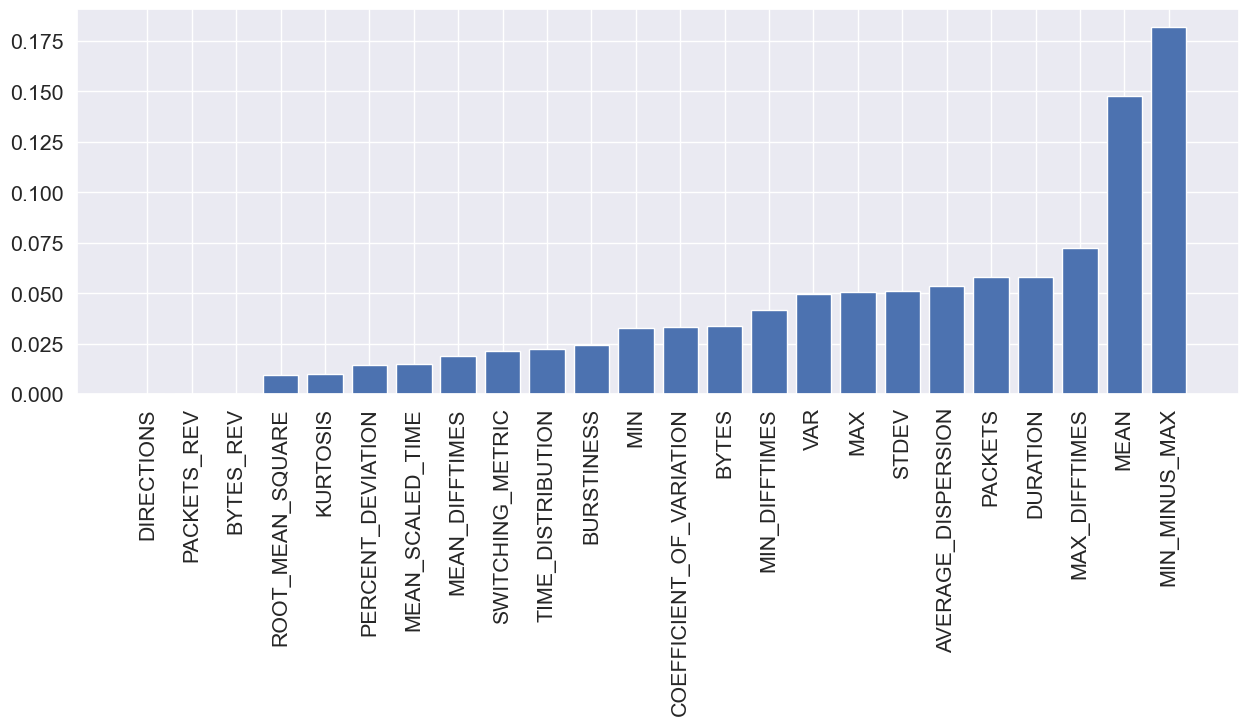

In [77]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()